In [1]:
#import common modules
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso

#import own modules
from source.plotting_exploration import plot_bias_variance_tradeoff_polynomial_degree_kfold


## Notebook for assignment 1 part H

Generating analysis plots for assignement 1 part h, cross validation. 

* Functions for the main methods can be found in source/main_methods.py
* Functions generating and scaling the feature matrix can be found in source/matrix_creation.py 
* Functions for calculating errors can be found in source/errors.py
* Functions for plotting and exploration can be found in source/plotting_exploration.py


### Setup for constants

In [2]:
# Runge's function - parameters to explore
n_datapoints = 1000
standard_deviation = 0.1 # for noise
p = 15 # polynomial degree

lambda_range = (-1,-5) # range of lambda values for np.log
lambda_n = 20 # number lambda values to explore
lambdas_start = np.logspace(lambda_range[0],lambda_range[1],lambda_n) # lambdas generated in logspace for learning rate

# Grid search
etas = [0.001, 0.005, 0.01, 0.05, 0.1] # gradient descent parameters

# tolerance criteria for gradient descent methods
tolerance = 1e-6
max_iterations = 1000

use_intercept = True 
create_plots = False
verbose_bool = False

np.random.seed(250)  # ensure reproducibility numpy
random_state_int = 42   # ensure reproducibility train_test_split

### Set up function

In [3]:
def runge_function(x):
    """
        The Runge function, f(x) = 1/(1+25*x^2)

        Returns
        -------
        f : numpy array shape (n)
            the Runge function evaluated at each point in x

        Parameters
        ----------
        x : numpy array shape (n)
            x values from dataset
    """

    f = 1/(1+25*x**2) 

    return f

### Generate Runge's function data

In [4]:
# generate data
np.random.seed(2025)
n_samples = 100
x = np.linspace(-1, 1, n_samples).reshape(-1, 1)
y = runge_function(x) + 0.1 * np.random.normal(size=n_samples)

### Generate feature matrix, scale and split into training and test data

#### No noise

Set up and scale the data

In [5]:
degree = 5
poly = PolynomialFeatures(degree=degree)
X_poly = poly.fit_transform(x.reshape(-1,1))

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_poly)


Set up k-fold cross-validation

In [6]:
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=2025)
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=0.001)
}
results = {name: {'mse': [], 'r2': []} for name in models.keys()}


Perform k-fold cross-validation

In [7]:
# perform k-fold cross-validation
for train_index, test_index in kf.split(X_scaled):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        results[name]['mse'].append(mse)
        results[name]['r2'].append(r2)

Print results

In [8]:
# print results
for name, metrics in results.items():
    avg_mse = np.mean(metrics['mse'])
    avg_r2 = np.mean(metrics['r2'])
    print(f"{name} - Average MSE: {avg_mse:.4f}, Average R²: {avg_r2:.4f}")

Linear Regression - Average MSE: 0.0197, Average R²: 0.6551
Ridge Regression - Average MSE: 0.0202, Average R²: 0.6843
Lasso Regression - Average MSE: 0.0189, Average R²: 0.6774


Plot results

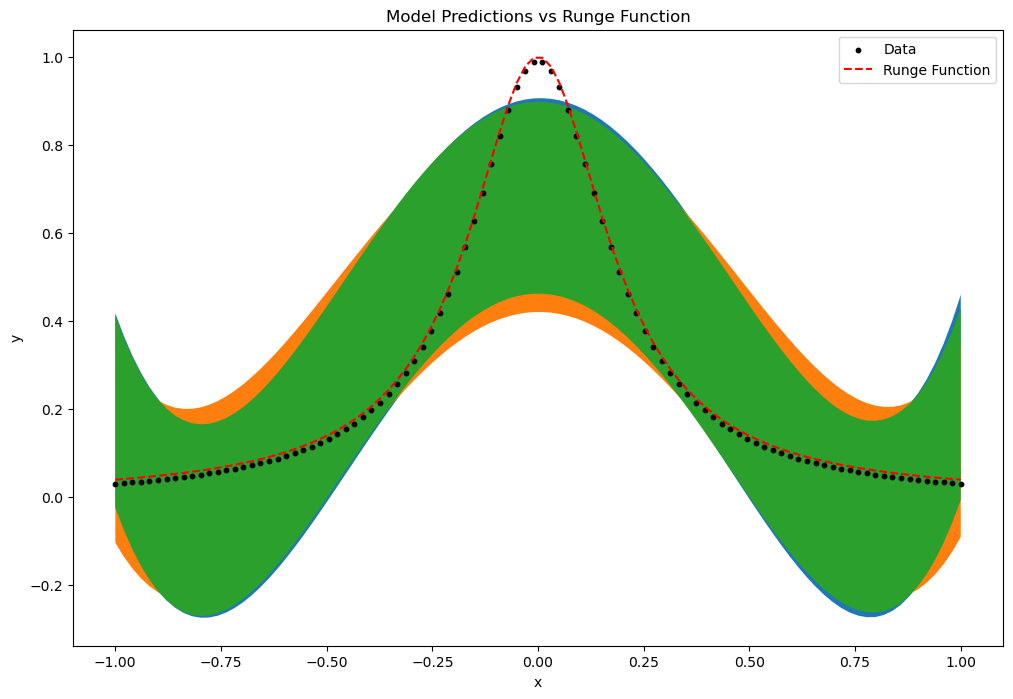

In [9]:
colors = {
    'Linear Regression': 'blue',
    'Ridge Regression': 'green',
    'Lasso Regression': 'orange',
    'Runge Function': 'red',
    'Data': 'black'
}

x_plot = np.linspace(-1, 1, 100).reshape(-1, 1)
X_plot_poly = poly.transform(x_plot)
X_plot_scaled = scaler.transform(X_plot_poly)

plt.figure(figsize=(12, 8))

for name, model in models.items():
    y_plot = model.predict(X_plot_scaled)
    plt.fill_between(x_plot.ravel(), np.max(y_plot,axis=1), np.min(y_plot,axis=1))
    #plt.plot(x_plot, np.max(y_plot,axis=1), label=name, color=colors[name])
    
plt.scatter(x, y if y.ndim == 1 else y[:, 0], color=colors['Data'], label='Data', s=10)
plt.plot(x_plot, runge_function(x_plot), label='Runge Function', linestyle='--', color=colors['Runge Function'])
plt.title('Model Predictions vs Runge Function')
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.xlabel('x')
plt.ylabel('y')
plt.savefig("cross-validation.png")      
plt.show()        


Lasso Regression (alpha=0.0001) - MSE: 0.0110, R²: 0.3060
Lasso Regression (alpha=0.001) - MSE: 0.0102, R²: 0.3529
Lasso Regression (alpha=0.01) - MSE: 0.0094, R²: 0.4048
Lasso Regression (alpha=0.1) - MSE: 0.0214, R²: -0.3541
Lasso Regression (alpha=1) - MSE: 0.0396, R²: -1.5069


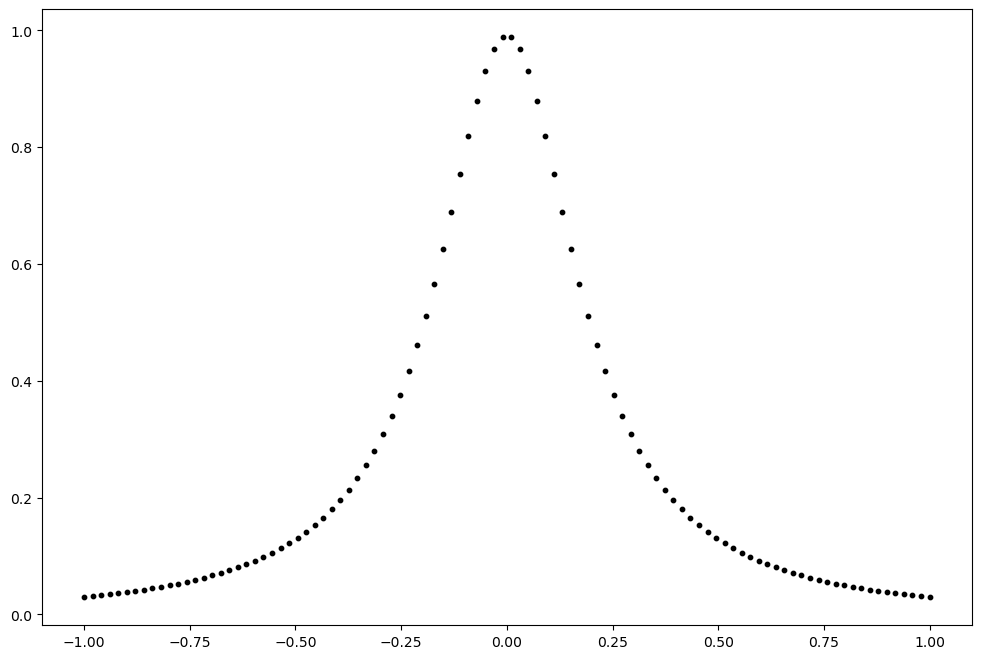

In [10]:
for a in [1e-4, 1e-3, 1e-2, 1e-1, 1]:
    model = Lasso(alpha=a, max_iter=10000)
    # kjør CV og print MSE / R2
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"Lasso Regression (alpha={a}) - MSE: {mse:.4f}, R²: {r2:.4f}")
# plot results with fixed colors for each model and data
colors = {
    'Linear Regression': 'blue',
    'Ridge Regression': 'green',            
    'Lasso Regression': 'orange',
    'Runge Function': 'red',
    'Data': 'black'
}
x_plot = np.linspace(-1, 1, 100).reshape(-1, 1)
X_plot_poly = poly.transform(x_plot)
X_plot_scaled = scaler.transform(X_plot_poly)
plt.figure(figsize=(12, 8))
plt.scatter(x, y if y.ndim == 1 else y[:, 0], color
=colors['Data'], label='Data', s=10)
for name, model in models.items():
    y_plot = model.predict(X_plot_scaled)


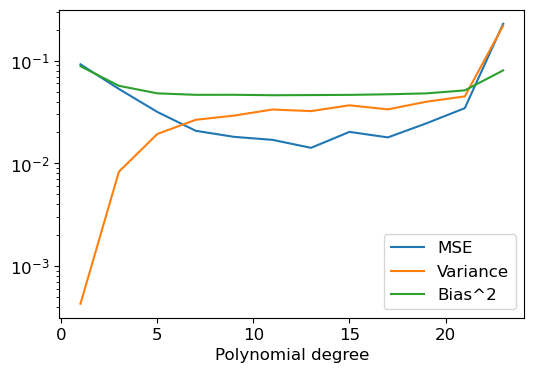

In [11]:
np.random.seed(350)
# using noisy data
x_noise = np.linspace(-1, 1, num=100)
y_noise = (1 / (1 + 25 * x_noise**2)) + np.random.normal(0, 0.1, size=x_noise.size)

plot_bias_variance_tradeoff_polynomial_degree_kfold(x_noise, y_noise, max_p=24, k=5)